In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from scipy.ndimage import fourier_shift, gaussian_filter

from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

from photutils.detection import DAOStarFinder, find_peaks

from astropy.io import fits

%matplotlib widget

In [7]:

def source_masked_background(image, sources, smoothing_sigma=50, method='gaussian'):
    """
    Remove low-frequency background patterns using source masking.
    
    Parameters
    ----------
    image : 2D array
        Input image.
    sources : Nx3 array (y,x,flux)
        Sources to mask.
    smoothing_sigma : float
        Sigma for Gaussian smoothing / low-pass filter.
    method : str
        'gaussian' for Gaussian smoothing, 'fft' for Fourier low-pass.
    
    Returns
    -------
    bg_subtracted : 2D array
        Image with background removed.
    bg_map : 2D array
        Estimated background map.
    """
    mask = np.ones_like(image, dtype=bool)
    for x, y in sources:
        iy, ix = int(round(y)), int(round(x))
        if 0 <= iy < image.shape[0] and 0 <= ix < image.shape[1]:
            mask[iy-2:iy+3, ix-2:ix+3] = False  # small mask around star
    
    masked_img = image.copy()
    masked_img[~mask] = 0.0  # zero out sources for smoothing
    
    if method == 'gaussian':
        bg_map = gaussian_filter(masked_img, sigma=smoothing_sigma)
    elif method == 'fft':
        # FFT-based low-pass filtering
        f = fft2(masked_img)
        ny, nx = image.shape
        fy, fx = np.meshgrid(np.fft.fftfreq(nx), np.fft.fftfreq(ny))
        r = np.sqrt(fx**2 + fy**2)
        f[r>1/smoothing_sigma] = 0
        bg_map = np.real(ifft2(f))
    else:
        raise ValueError("method must be 'gaussian' or 'fft'")
    
    bg_subtracted = image - bg_map
    return bg_subtracted, bg_map


In [8]:
def position_func(data):

    nddata = NDData(data=data) 
    mean, median, std = sigma_clipped_stats(data, sigma=3.0) 

    fwhm = 5

    daofind = DAOStarFinder(fwhm=fwhm, threshold=10.*std)  
    sources = daofind(data) 

    sources.sort('flux', reverse=True)
    
    sharp = sources['sharpness']
    round1 = sources['roundness1']
    round2 = sources['roundness2']

    # Define your constraints (tweak these for your data)
    sharp_min, sharp_max = 0.2, 0.95       # Ideal stars are neither too sharp nor too broad
    round1_min, round1_max = -0.5, 0.5    # Closer to 0 means round
    round2_min, round2_max = -0.5, 0.5    # Symmetric roundness in both axes

    mask = (
        (sharp > sharp_min) & (sharp < sharp_max) &
        (round1 > round1_min) & (round1 < round1_max) &
        (round2 > round2_min) & (round2 < round2_max)
    )

    filtered_sources = sources[mask]

    positions = np.zeros((len(filtered_sources), 2))
    positions[:,0] = filtered_sources['xcentroid'].value
    positions[:,1] = filtered_sources['ycentroid'].value
    
    
    return positions, nddata

In [4]:
files = ['i', 'r', 'g']
f_files = []

for f in files:
    file = f'/Users/zgl12/Python_Scripts/Image_Processing/ygp/2023ygp-0011_{f}_wcs.fits.gz'

    hdu = fits.open(file)
    image_data = hdu[0].data -500
    hdu.close()

    # f_files.append(image_data)
    break
    

In [5]:
positions, nddata = position_func(image_data)

In [20]:
# bg_subtracted, bg_map = source_masked_background(image_data, positions, smoothing_sigma=50, method='gaussian')

tgt_clean = image_data.copy()
for i in range(1):
    tgt_clean, tgt_bg = source_masked_background(tgt_clean, positions, smoothing_sigma=1, method='fft')
    
    tgt_clean -= np.nanmedian(tgt_clean)

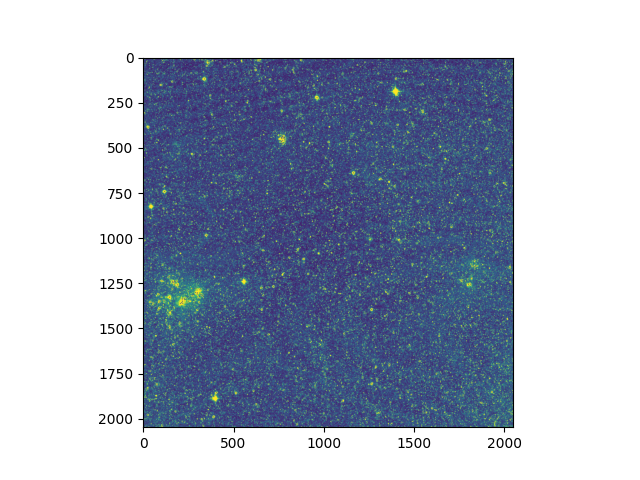

In [22]:
plt.figure()
plt.imshow(tgt_bg, vmin = np.nanpercentile(tgt_bg, 5), vmax = np.nanpercentile(tgt_bg, 98))
plt.show()

In [ ]:
import numpy as np
from scipy.fft import fft2, ifft2, fftshift
from scipy.ndimage import fourier_shift, gaussian_filter
from astroscrappy import detect_cosmics
from photutils.psf.matching import create_matching_kernel, TukeyWindow
from astropy.convolution import convolve
from copy import deepcopy

def iterative_difference_pipeline(ref_image, target_image, 
                                  sources_ref=None, sources_target=None,
                                  n_iter=2, mask_cr=False,
                                  psf_ref=None, psf_target=None,
                                  tile_size=(128,128), sigma_weight=1.5):
    """
    ref_image: 2D numpy array, reference image
    target_image: 2D numpy array, target image to align and match
    sources_ref / sources_target: arrays of sources (y,x[,flux])
    n_iter: number of refinement iterations
    mask_cr: whether to remove cosmic rays
    psf_ref / psf_target: EPSFs
    tile_size: for spatially varying kernel
    sigma_weight: smoothing for weight map
    """
    
    ref = ref_image.copy()
    tgt = target_image.copy()
    
    def ensure_sources(sources, shape):
        """
        Convert Nx2 (x,y) or Nx3 (x,y,flux) source list to Nx3 (y,x,flux)
        """
        if sources is None:
            return np.column_stack(np.where(np.ones(shape)))[:,:3]

        sources = np.array(sources)
        
        # Swap x,y -> y,x
        if sources.shape[1] == 2:
            x = sources[:,0]
            y = sources[:,1]
            flux = np.ones(len(sources))
            sources = np.column_stack([y, x, flux])
        elif sources.shape[1] == 3:
            # assume x,y,flux -> y,x,flux
            x = sources[:,0]
            y = sources[:,1]
            f = sources[:,2]
            sources = np.column_stack([y, x, f])
        else:
            raise ValueError("Source array must have shape Nx2 or Nx3")
        
        return sources

    
    sources_ref = ensure_sources(sources_ref, ref)
    sources_target = ensure_sources(sources_target, tgt)
    
    for i in range(n_iter):
        # --- Optional cosmic ray removal ---
        if mask_cr:
            crmask_ref, ref_clean = detect_cosmics(ref, sigclip=4.5, cleantype='medmask')
            crmask_tgt, tgt_clean = detect_cosmics(tgt, sigclip=4.5, cleantype='medmask')
        else:
            ref_clean = ref.copy()
            tgt_clean = tgt.copy()
        
        # --- Background refinement ---
        # simple median subtraction (could upgrade to 2D polynomial if needed)
        ref_med = np.nanmedian(ref_clean)
        tgt_med = np.nanmedian(tgt_clean)
        ref_clean -= ref_med
        tgt_clean -= tgt_med
        
        # --- Weighted subpixel alignment ---
        def create_weight_map(shape, sources, sigma=1.0):
            weight_map = np.zeros(shape)
            for y, x, flux in sources:
                iy, ix = int(round(y)), int(round(x))
                if 0 <= iy < shape[0] and 0 <= ix < shape[1]:
                    weight_map[iy, ix] += flux
            if sigma>0:
                weight_map = gaussian_filter(weight_map, sigma=sigma)
            return weight_map
        
        w_ref = create_weight_map(ref_clean.shape, sources_ref, sigma=sigma_weight)
        w_tgt = create_weight_map(tgt_clean.shape, sources_target, sigma=sigma_weight)
        
        f_ref = fft2(ref_clean * w_ref)
        f_tgt = fft2(tgt_clean * w_tgt)
        cross_power = (f_ref * f_tgt.conj()) / np.abs(f_ref * f_tgt.conj())
        cc = fftshift(ifft2(cross_power).real)
        max_idx = np.unravel_index(np.argmax(cc), cc.shape)
        shifts = np.array(max_idx) - np.array(cc.shape)//2
        
        # Apply subpixel shift
        tgt_clean = np.real(ifft2(fourier_shift(fft2(tgt_clean), shifts)))
        
        # --- Spatially varying PSF matching ---
        if psf_ref is not None and psf_target is not None:
            ny, nx = ref_clean.shape
            ty, tx = tile_size
            corrected = np.zeros_like(tgt_clean)
            for i0 in range(0, ny, ty):
                for j0 in range(0, nx, tx):
                    i1 = min(i0+ty, ny)
                    j1 = min(j0+tx, nx)
                    tgt_tile = tgt_clean[i0:i1,j0:j1]
                    # create_matching_kernel can handle small tiles
                    taper = TukeyWindow(alpha=0.5)
                    kernel = create_matching_kernel(psf_target, psf_ref, window=taper)
                    corrected[i0:i1,j0:j1] = convolve(tgt_tile, kernel)
            tgt_clean = corrected
        
        # Update target for next iteration
        tgt = tgt_clean
    
    # --- Final difference image ---
    diff = ref_clean - tgt_clean
    
    return diff, tgt_clean, shifts
